In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from einops import rearrange, repeat
from random import randint
from dataset import ImageDataset
from vit_trainer import VitTrainer

import matplotlib.pyplot as plt
import numpy as np

from utils import permute_image, topk_acc, greedy_refine_pred_perm, unnormalize_image
from copy import deepcopy

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [4]:
ckpt = VitTrainer.load_from_checkpoint('logs/o1wcbpvb-100-e66.ckpt')
cfg = ckpt.cfg

vit_trainer = VitTrainer(cfg)
vit_trainer.load_state_dict(ckpt.state_dict())

vit = vit_trainer.model.to(device)
vit = vit.eval()

dataset = ImageDataset(
    '/data/group_data/neuroagents_lab/pixi/OpenImagesV7/train_0',
    cfg.image_paths_pkl,
)

Selected index: 56750


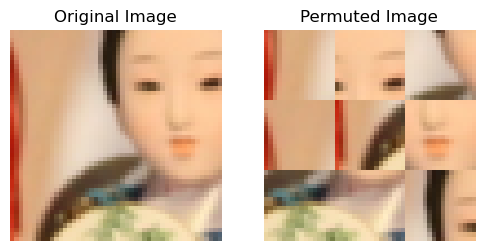

torch.Size([3, 48, 48])


In [7]:
# idx = randint(0, len(dataset) - 1)
# idx = 50398
# idx = 16559
idx = 56750
print(f'Selected index: {idx}')
orig_image = ckpt.resize_image(dataset[idx])

# perm = torch.tensor([1, 0, 2, 3, 4, 5, 6, 7, 8])
perm = None
perm_image, perm = permute_image(
    orig_image.clone(), patch_size=cfg.patch_size, perm=perm
)

fig, (a1, a2) = plt.subplots(1, 2, figsize=(6, 3))
a1.set_title('Original Image')
a2.set_title('Permuted Image')
a1.axis('off')
a2.axis('off')
a1.imshow(orig_image.permute(1, 2, 0))
a2.imshow(perm_image.permute(1, 2, 0))
plt.show()

print(orig_image.shape)

torch.Size([3, 48, 48])


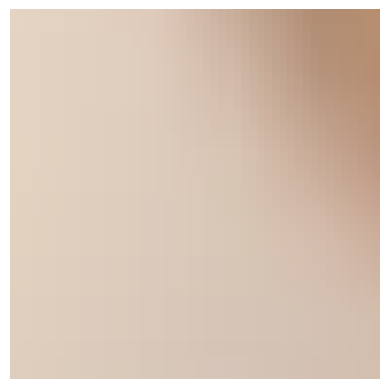

In [ ]:
t_image = vit_trainer.image_transforms(orig_image)
print(t_image.shape)
plt.imshow(unnormalize_image(t_image))
plt.axis('off')
plt.show()

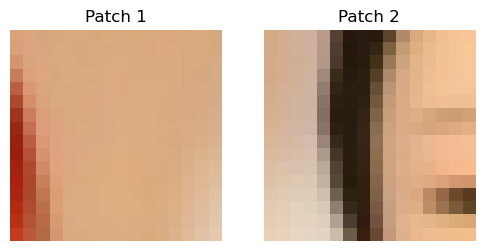

In [32]:
patch_1 = orig_image[:, 0:16, 0:16]
patch_2 = orig_image[:, 0:16, 16:32]

fig, (a1, a2) = plt.subplots(1, 2, figsize=(6, 3))
a1.set_title('Patch 1')
a2.set_title('Patch 2')
a1.axis('off')
a2.axis('off')
a1.imshow(patch_1.permute(1, 2, 0))
a2.imshow(patch_2.permute(1, 2, 0))
plt.show()

In [8]:
with torch.inference_mode():
    x = orig_image.unsqueeze(0).to(device)
    x = vit_trainer.image_transforms(x)
    # x = vit_trainer.norm_image(x)
    y = vit(x)
    rec = deepcopy(vit.rec)
    rect = deepcopy(vit.transformer.rec)
    pred_perm_1 = y.squeeze().argmax(dim=-1)

with torch.inference_mode():
    x = perm_image.unsqueeze(0).to(device)
    x = vit_trainer.norm_image(x)
    y = vit(x)
    p_rec = deepcopy(vit.rec)
    p_rect = deepcopy(vit.transformer.rec)
    pred_perm_2 = y.squeeze().argmax(dim=-1)

print('Original Image Prediction:')
print(pred_perm_1)

print('Permuted Image Prediction:')
print(pred_perm_2)

print('Permutation sequence:')
print(perm)

Original Image Prediction:
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])
Permuted Image Prediction:
tensor([3, 2, 4, 0, 6, 5, 7, 8, 1])
Permutation sequence:
tensor([3, 2, 4, 0, 6, 5, 7, 8, 1])


In [23]:
print(rec['x_pe'][0, :5])
print(p_rec['x_pe'][0, :5])
print(torch.allclose(rec['x_pe'], p_rec['x_pe']))

tensor([-0.7265, -0.4067, -0.4904,  0.2373,  0.3030])
tensor([-0.7265, -0.4067, -0.4904,  0.2373,  0.3030])
True


In [29]:
patch_emb = vit.to_patch_embedding[2]

In [35]:
patch_1.shape

torch.Size([3, 16, 16])

In [38]:
emb_1 = patch_emb(patch_1.float().flatten())
emb_2 = patch_emb(patch_2.float().flatten())

In [39]:
print(emb_1[:5])
print(emb_2[:5])

tensor([ 151.3275,   68.5576,  -72.3483, -109.6656,   43.6561],
       grad_fn=<SliceBackward0>)
tensor([130.5655,  42.1755,  -7.7610, -86.4977,  92.3857],
       grad_fn=<SliceBackward0>)


In [ ]:
gt = ckpt.gt_single[:, perm].expand(y.size(0), -1)
# gt = vit_trainer.gt_single[:].expand(y.size(0), -1)
t1_acc = topk_acc(y, gt, k=1)
t5_acc = topk_acc(y, gt, k=5)
print(f'Top-1 accuracy: {t1_acc:.4f}')
print(f'Top-5 accuracy: {t5_acc:.4f}')

Top-1 accuracy: 0.0000
Top-5 accuracy: 0.5556


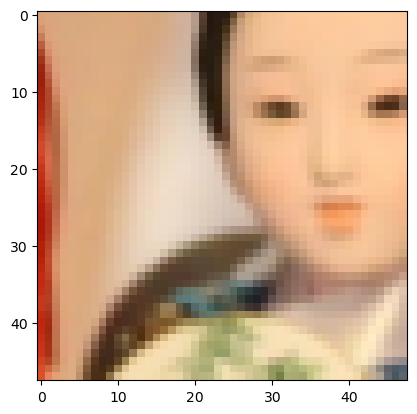

In [ ]:
# recon_image, _ = permute_image(input_image, cfg.patch_size, pred_perm)

# We purposefully do permute_image(img, ..., pred_perm)
# which comes up as a nearly non-scrambled, normal image.
# i.e. we show that the pred_perm is (nearly) an identity [0, 1, 2, 3, ...]

recon_image, _ = permute_image(orig_image, cfg.patch_size, pred_perm)
plt.imshow(recon_image.permute(1, 2, 0))
plt.show()

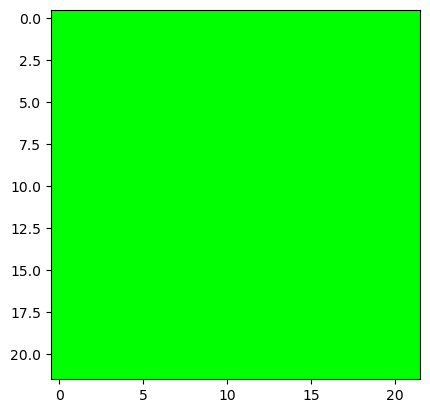

In [65]:
# Visualize the top-1 error locations
# If a patch position is predicted wrong, it will be colored red
# Otherwise, it will be colored green.


def visualize_top1_error(recon_image, pred_perm: torch.tensor, gt_perm: torch.tensor):
    gt_perm = gt_perm.squeeze()
    n_side = cfg.crop_image_to_px // cfg.patch_size
    errors = torch.where(pred_perm != gt_perm)[0]

    r = errors // n_side
    c = errors % n_side

    overlay = torch.zeros((n_side, n_side, 3), dtype=torch.float32)
    overlay[:] = torch.tensor([0, 1, 0], dtype=torch.float32)
    overlay[r, c] = torch.tensor([1, 0, 0], dtype=torch.float32)

    # Blend the overlay with the image
    # recon_image = recon_image.permute(1, 2, 0).cpu().numpy()

    plt.imshow(overlay)
    plt.show()


visualize_top1_error(recon_image, pred_perm, gt)